# Dask Array

This notebook gives a quick demo of using `dask.array`. It is not intended to be a full tutorial on using dask, or a full demonstration of its capabilities. For more information see the docs [here](http://dask.pydata.org/en/latest/), or some live notebooks [here](http://mybinder.org/repo/blaze/dask-examples).

## Create an array

In [1]:
import dask.array as da
import numpy as np

### Create a dask array
Dask arrays can be created in a few different ways, but here we'll use the `from_array` function. `from_array` accepts anything that works with numpy style slicing, so we could pass in an hdf5 or netcdf4 Dataset instead of a numpy array. We'll use a numpy array here just for a quick demo. We also pass in a `chunks` keyword, which tells dask how to block the array into chunks.

In [2]:
x = np.arange(3000**2).reshape((3000, 3000))
a = da.from_array(x, chunks=(750, 750))

### Examine the array
`a` now is a `dask.array.Array` object, which looks a lot like a numpy array. It has many of the same methods even:

In [3]:
print([f for f in dir(a) if not f.startswith('_')])

['T', 'all', 'any', 'argmax', 'argmin', 'astype', 'cache', 'chunks', 'compute', 'conj', 'dask', 'dot', 'dtype', 'flatten', 'imag', 'map_blocks', 'map_overlap', 'max', 'mean', 'min', 'moment', 'name', 'nbytes', 'ndim', 'numblocks', 'prod', 'ravel', 'real', 'rechunk', 'reshape', 'shape', 'size', 'squeeze', 'std', 'store', 'sum', 'to_hdf5', 'topk', 'transpose', 'var', 'vindex', 'visualize', 'vnorm']


In [4]:
a.shape

(3000, 3000)

In [5]:
a.dtype

dtype('int64')

Computations done on the array are not run immediately, but recorded in a graph as a `dask` attribute on the array. This is common for all dask collections (`dask.array`, `dask.dataframe`, `dask.bag` and `dask.imperative`). To see the graph, one can use the `visualize` method:

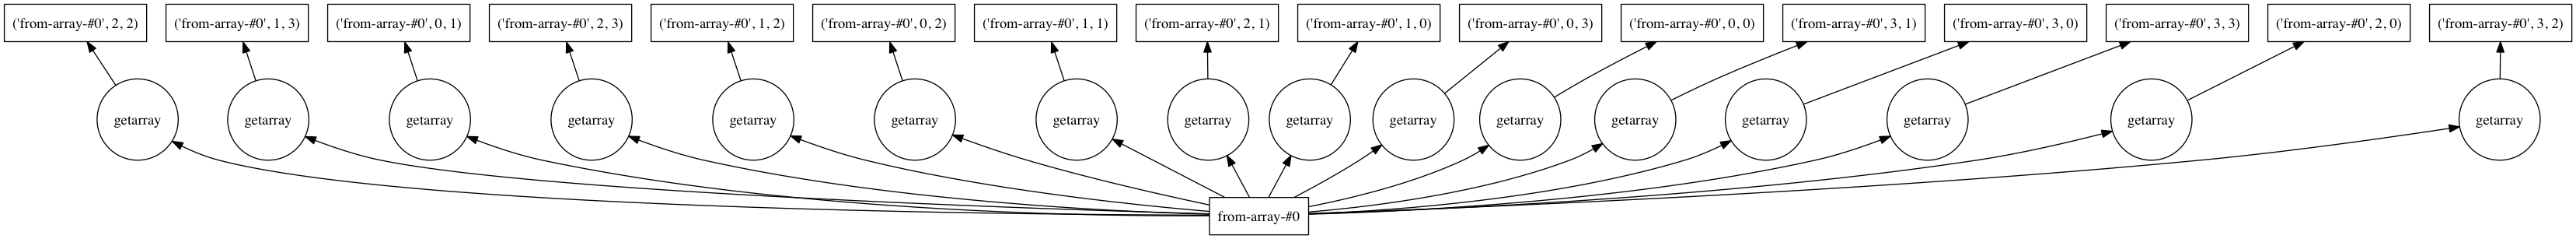

In [6]:
a.visualize()

The graph of `a` just shows several slices being taken out of `x` - one for each chunk. Lets create a larger computation, and visualize it:

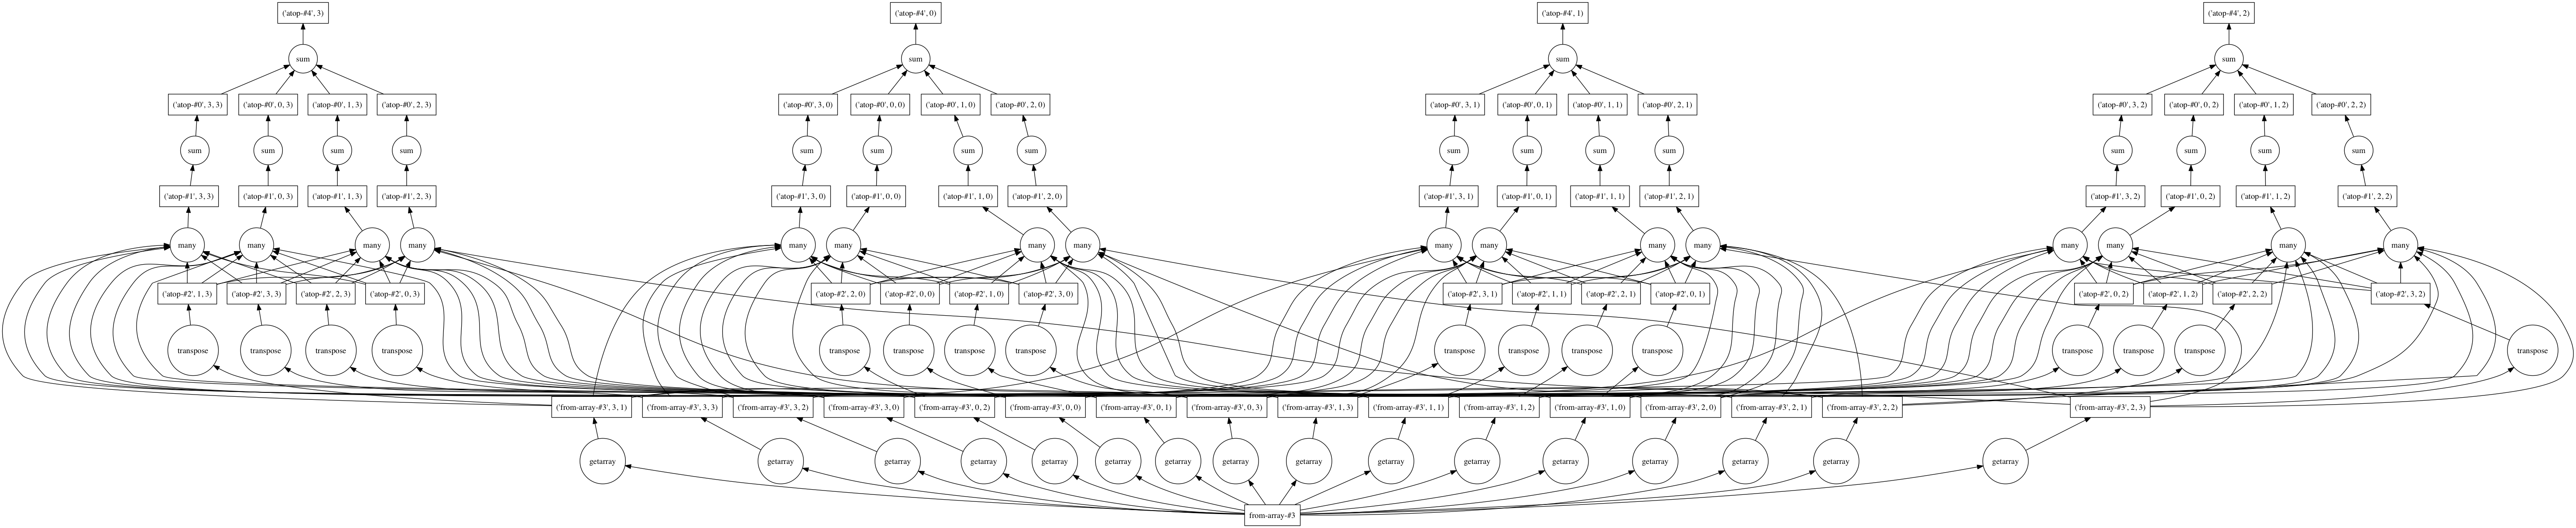

In [7]:
expr = a.dot(a.T).sum(axis=0)
expr.visualize()

That's quite a complicated graph! Before the computation is actually run (by calling the `compute` method on the array), the graph is simplified with several optimization passes to improve efficiency. To visualize the final graph to be run, we can set the `optimize_graph` keyword as `True`:

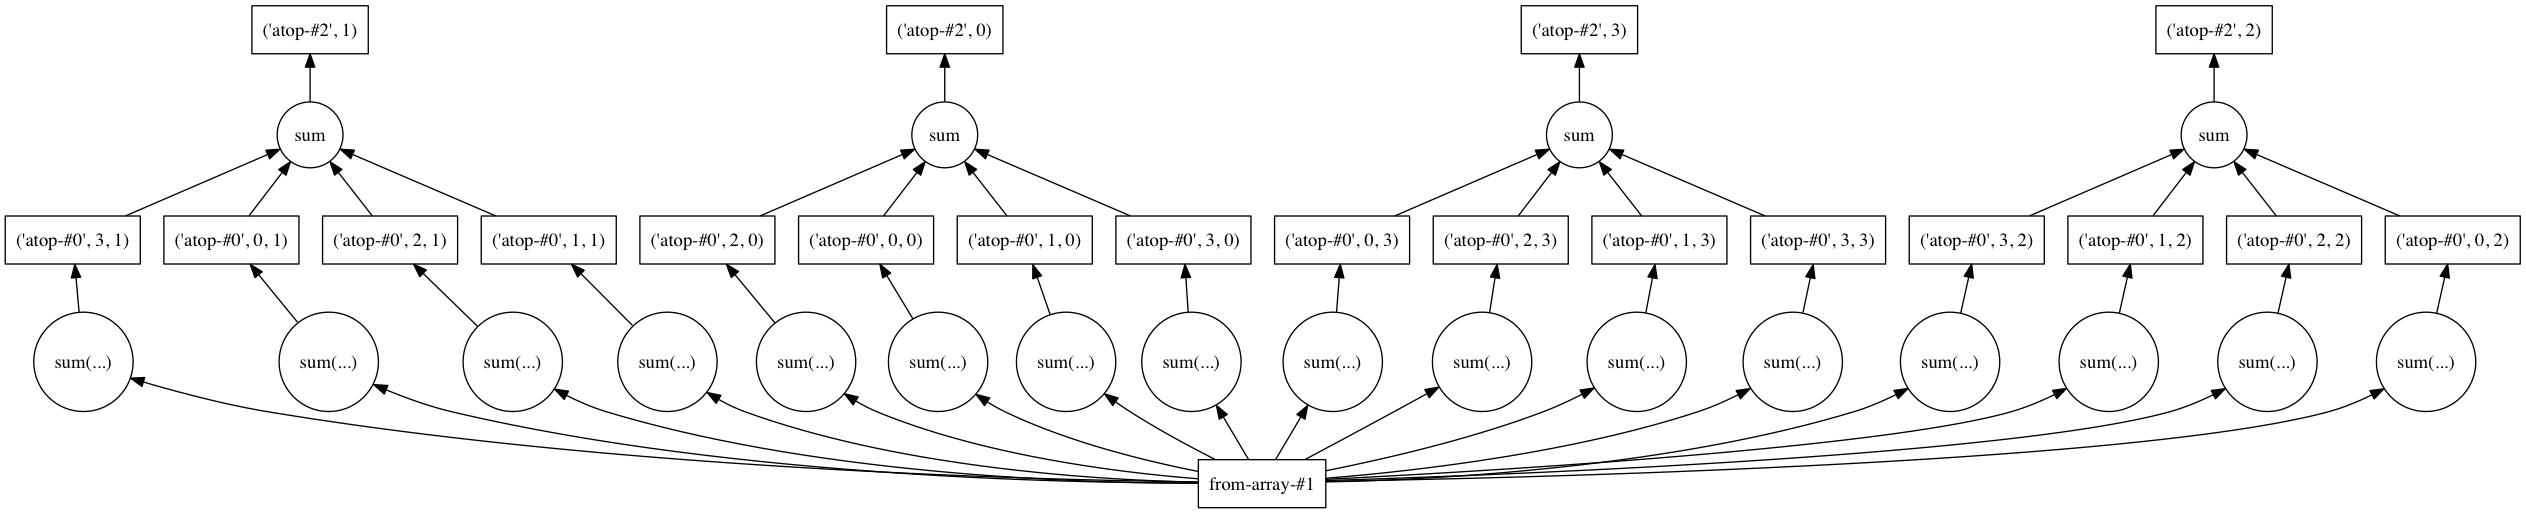

In [8]:
expr.visualize(optimize_graph=True)

This is a much simpler computation, and is the result of inlining, fusing, and rewriting tasks.

### Perform the actual computation
To actually run the computation, we can call the `compute` method. 

We'll also load some diagnostic tools so we can profile the computation afterwards. To read more about the diagnostic options in dask, see the docs [here](http://dask.pydata.org/en/latest/diagnostics.html).


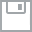
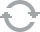
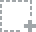
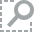
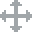
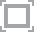
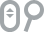
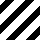
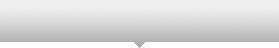
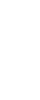
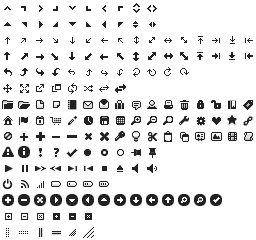
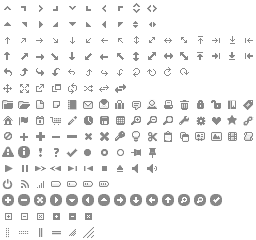
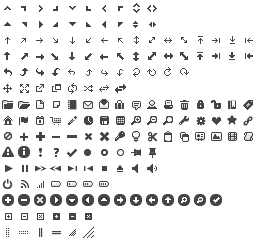
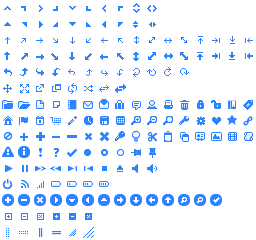
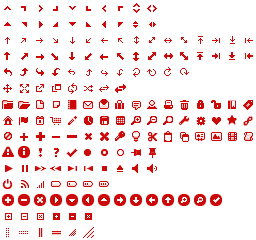
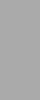
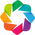
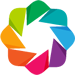

In [9]:
from dask.diagnostics import Profiler, ResourceProfiler, ProgressBar, visualize
from bokeh.io import output_notebook
ProgressBar().register()
output_notebook()

In [10]:
with ResourceProfiler(dt=0.5) as rprof, Profiler() as prof:
    out = expr.compute(num_workers=4)

[########################################] | 100% Completed |  4.5s


Here we'll plot a profile of the computation as executed by dask. The top plot has a box for each task showing the duration of the task (hover over the box with your mouse to see the task description). The bottom plot shows our resource usage.

As can be seen in this plot, we used 400% cpu, indicating all 4 cores of my computer were fully used.

In [11]:
visualize([prof, rprof])

Lets run the same computation in NumPy:

In [12]:
%time _ = x.dot(x.T).sum(axis=0)

CPU times: user 16 s, sys: 48.5 ms, total: 16.1 s
Wall time: 16.1 s


This took roughly 4 times as long as the computation in dask, showing that for large enough arrays, the parallelism from dask provides significant speedup.